In [14]:
import xarray
import numpy
import matplotlib.pyplot as plt
import os.path
import scipy.fft

In [2]:
Times=slice(0,50)
def Zsp(ds):
    ni = ds.RV.shape[-1]-1
    zhat = scipy.fft.rfft( ds.RV.isel(Time=Times,zl=0,yq=slice(1,None),xq=slice(1,None)).data )/ni
    dx = (ds.xq[1]-ds.xq[0]).values
    k = scipy.fft.rfftfreq(ni, d=dx )
    k = 2/dx * numpy.sin( 0.5 * dx * k )
    Z = numpy.real( zhat.conjugate() * zhat ).mean(axis=(0,1))
    return k, Z

def KEsp(ds):
    ni = ds.v.shape[-1]
    uhat = scipy.fft.rfft( ds.u.isel(Time=Times,zl=0,xq=slice(1,None)).data )/ni
    vhat = scipy.fft.rfft( ds.v.isel(Time=Times,zl=0,yq=slice(1,None)).data )/ni
    dx = (ds.xq[1]-ds.xq[0]).values
    k = scipy.fft.rfftfreq(ni, d=dx )
    k = 2/dx * numpy.sin( 0.5 * dx * k )
    E = numpy.real( uhat.conjugate() * uhat + vhat.conjugate() * vhat ).mean(axis=(0,1))
    return k, E

def Zpdf(ds):
    p,b = numpy.histogram( 1e4*ds.RV.isel(Time=Times,zl=0), bins=numpy.linspace(-0.5,1.,151));
    return 0.5*(b[:-1]+b[1:]), p/p.sum()

In [37]:
AHdt90 = xarray.open_dataset('ArakawaHsu.Smag006.dt90.512x512/prog.nc')
AHdt100 = xarray.open_dataset('ArakawaHsu.Smag006.dt100.512x512/prog.nc')
AHdt120 = xarray.open_dataset('ArakawaHsu.Smag006.dt120.512x512/prog.nc')
AHdt150 = xarray.open_dataset('ArakawaHsu.Smag006.dt150.512x512/prog.nc')
AHdt180 = xarray.open_dataset('ArakawaHsu.Smag006.dt180.512x512/prog.nc')
AHdt120gw = xarray.open_dataset('ArakawaHsu.Smag006.dt120.begw0.9.512x512/prog.nc')
AHdt180gw = xarray.open_dataset('ArakawaHsu.Smag006.dt180.begw0.9.512x512/prog.nc')
AHdt180gw1 = xarray.open_dataset('ArakawaHsu.Smag006.dt180.begw0.1.512x512/prog.nc')
AHdt180gw01 = xarray.open_dataset('ArakawaHsu.Smag006.dt180.begw0.01.512x512/prog.nc')

Ld=xarray.open_dataset('ArakawaHsu.Smag006.dt150.512x512/ave_prog.nc', decode_cf=False).Rd1.max(axis=0)
cg1 = (1e-4*Ld).max().values

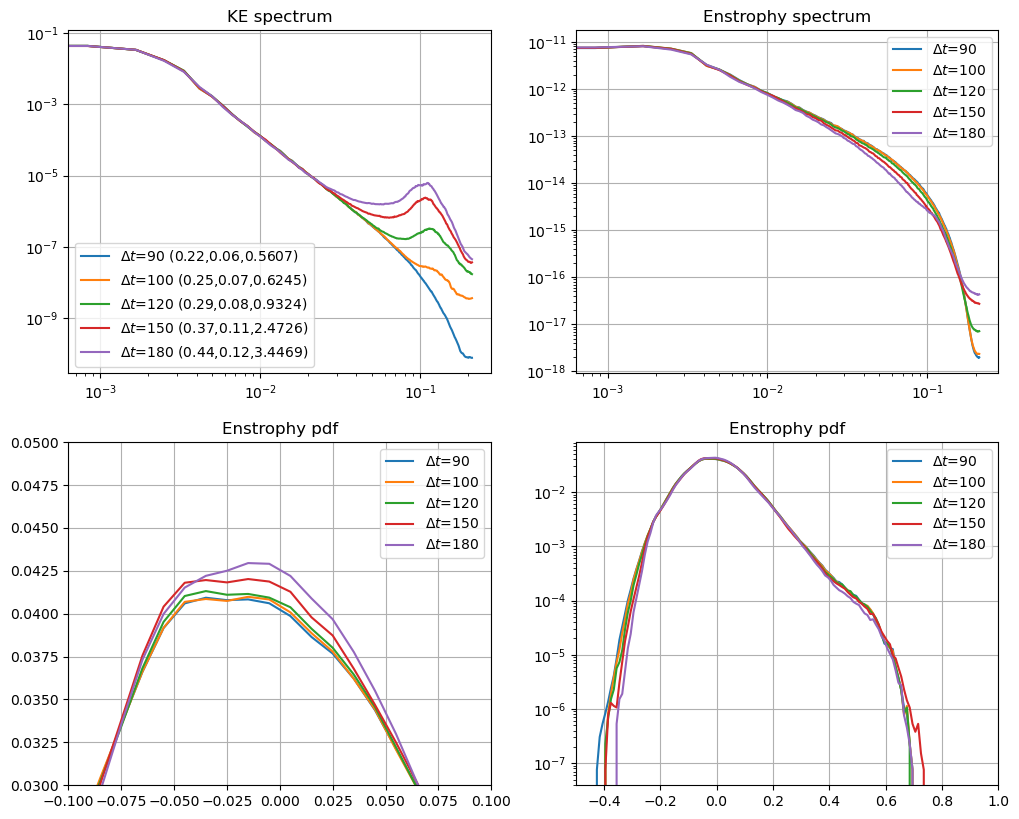

In [18]:
def plot(pfn, fn, ds, dt):
    dxk = (ds.xq[1] - ds.xq[0]).values
    dx = dxk*1e3
    U = ds.u.max().values
    A = ds.Ahh.max().values
    pfn( *fn( ds ), label='$\Delta t$=%i (%.2f,%.2f,%.4f)'%(dt,dt*cg1/dx,dt*U/dx,dt*A*(6.28/dx)**4) )

plt.figure(figsize=(12,10),dpi=100);

plt.subplot(2,2,1)
plot( plt.loglog, KEsp, AHdt90, 90);
plot( plt.loglog, KEsp, AHdt100, 100);
plot( plt.loglog, KEsp, AHdt120, 120);
plot( plt.loglog, KEsp, AHdt150, 150);
plot( plt.loglog, KEsp, AHdt180, 180);
plt.legend(); plt.grid(); plt.title('KE spectrum');

plt.subplot(2,2,2)
plt.loglog( *Zsp( AHdt90 ), label='$\Delta t$=90' );
plt.loglog( *Zsp( AHdt100 ), label='$\Delta t$=100' );
plt.loglog( *Zsp( AHdt120 ), label='$\Delta t$=120' );
plt.loglog( *Zsp( AHdt150 ), label='$\Delta t$=150' );
plt.loglog( *Zsp( AHdt180 ), label='$\Delta t$=180' );
plt.legend(); plt.grid(); plt.title('Enstrophy spectrum');

plt.subplot(2,2,3)
plt.plot( *Zpdf( AHdt90 ), label='$\Delta t$=90' );
plt.plot( *Zpdf( AHdt100 ), label='$\Delta t$=100' );
plt.plot( *Zpdf( AHdt120 ), label='$\Delta t$=120' );
plt.plot( *Zpdf( AHdt150 ), label='$\Delta t$=150' );
plt.plot( *Zpdf( AHdt180 ), label='$\Delta t$=180' );
plt.legend(); plt.grid(); plt.title('Enstrophy pdf');
plt.xlim(-.1,.1); plt.ylim(.03,.05);

plt.subplot(2,2,4)
plt.semilogy( *Zpdf( AHdt90 ), label='$\Delta t$=90' );
plt.plot( *Zpdf( AHdt100 ), label='$\Delta t$=100' );
plt.plot( *Zpdf( AHdt120 ), label='$\Delta t$=120' );
plt.plot( *Zpdf( AHdt150 ), label='$\Delta t$=150' );
plt.plot( *Zpdf( AHdt180 ), label='$\Delta t$=180' );
plt.legend(); plt.grid(); plt.title('Enstrophy pdf');
plt.xlim(-.5,1);


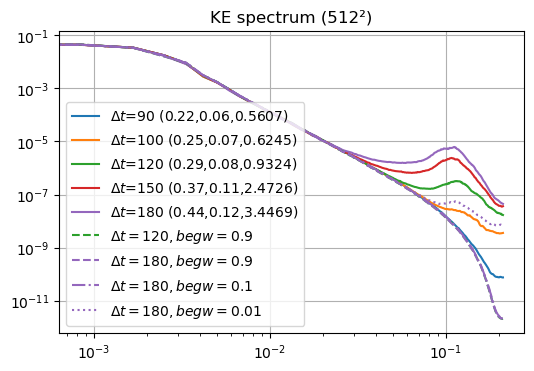

In [38]:
def plot(pfn, fn, ds, dt, *args, **kwargs):
    dxk = (ds.xq[1] - ds.xq[0]).values
    dx = dxk*1e3
    U = ds.u.max().values
    A = ds.Ahh.max().values
    if not 'label' in kwargs: kwargs['label'] = '$\Delta t$=%i (%.2f,%.2f,%.4f)'%(dt,dt*cg1/dx,dt*U/dx,dt*A*(6.28/dx)**4)
    pfn( *fn( ds ), *args, **kwargs )

plt.figure(dpi=100);

plot( plt.loglog, KEsp, AHdt90, 90);
plot( plt.loglog, KEsp, AHdt100, 100);
plot( plt.loglog, KEsp, AHdt120, 120);
plot( plt.loglog, KEsp, AHdt150, 150);
plot( plt.loglog, KEsp, AHdt180, 180);
plot( plt.loglog, KEsp, AHdt120gw, 120, '--C2', label='$\Delta t=120, begw=0.9$');
plot( plt.loglog, KEsp, AHdt180gw, 180, '--C4', label='$\Delta t=180, begw=0.9$');
plot( plt.loglog, KEsp, AHdt180gw1, 180, '-.C4', label='$\Delta t=180, begw=0.1$');
plot( plt.loglog, KEsp, AHdt180gw01, 180, ':C4', label='$\Delta t=180, begw=0.01$');
plt.legend(); plt.grid(); plt.title('KE spectrum (512²)');


In [6]:
AHdt180b = xarray.open_dataset('ArakawaHsu.Smag006.dt180.256x256/prog.nc')
AHdt240 = xarray.open_dataset('ArakawaHsu.Smag006.dt240.256x256/prog.nc')
AHdt300 = xarray.open_dataset('ArakawaHsu.Smag006.dt300.256x256/prog.nc')
AHdt360 = xarray.open_dataset('ArakawaHsu.Smag006.dt360.256x256/prog.nc')
AHdt400 = xarray.open_dataset('ArakawaHsu.Smag006.dt400.256x256/prog.nc')

Ld=xarray.open_dataset('ArakawaHsu.Smag006.dt300.256x256/ave_prog.nc', decode_cf=False).Rd1.max(axis=0)
cg1 = (1e-4*Ld).max().values

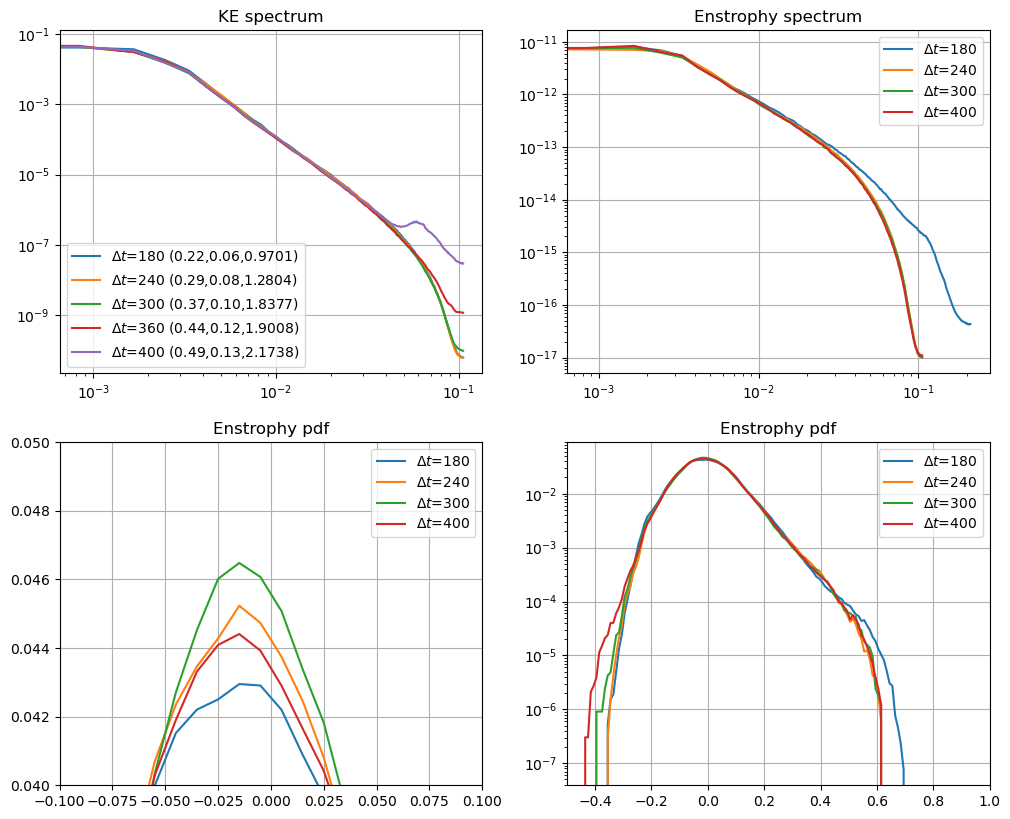

In [7]:
plt.figure(figsize=(12,10),dpi=100);

plt.subplot(2,2,1)
plot( plt.loglog, KEsp, AHdt180b, 180);
plot( plt.loglog, KEsp, AHdt240, 240);
plot( plt.loglog, KEsp, AHdt300, 300);
plot( plt.loglog, KEsp, AHdt360, 360);
plot( plt.loglog, KEsp, AHdt400, 400);
plt.legend(); plt.grid(); plt.title('KE spectrum');

plt.subplot(2,2,2)
plt.loglog( *Zsp( AHdt180 ), label='$\Delta t$=180' );
plt.loglog( *Zsp( AHdt240 ), label='$\Delta t$=240' );
plt.loglog( *Zsp( AHdt300 ), label='$\Delta t$=300' );
plt.loglog( *Zsp( AHdt400 ), label='$\Delta t$=400' );
plt.legend(); plt.grid(); plt.title('Enstrophy spectrum');

plt.subplot(2,2,3)
plt.plot( *Zpdf( AHdt180 ), label='$\Delta t$=180' );
plt.plot( *Zpdf( AHdt240 ), label='$\Delta t$=240' );
plt.plot( *Zpdf( AHdt300 ), label='$\Delta t$=300' );
plt.plot( *Zpdf( AHdt400 ), label='$\Delta t$=400' );
plt.legend(); plt.grid(); plt.title('Enstrophy pdf');
plt.xlim(-.1,.1); plt.ylim(.04,.05);

plt.subplot(2,2,4)
plt.semilogy( *Zpdf( AHdt180 ), label='$\Delta t$=180' );
plt.plot( *Zpdf( AHdt240 ), label='$\Delta t$=240' );
plt.plot( *Zpdf( AHdt300 ), label='$\Delta t$=300' );
plt.plot( *Zpdf( AHdt400 ), label='$\Delta t$=400' );
plt.legend(); plt.grid(); plt.title('Enstrophy pdf');
plt.xlim(-.5,1);


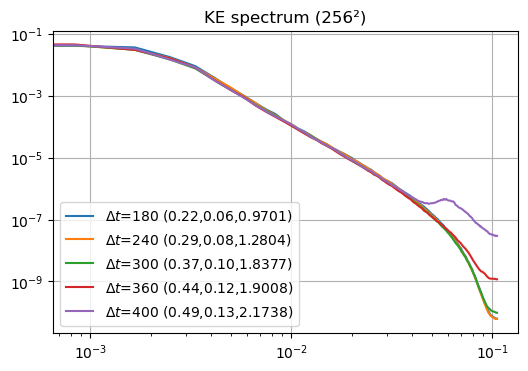

In [8]:
plt.figure(dpi=100);

plot( plt.loglog, KEsp, AHdt180b, 180);
plot( plt.loglog, KEsp, AHdt240, 240);
plot( plt.loglog, KEsp, AHdt300, 300);
plot( plt.loglog, KEsp, AHdt360, 360);
plot( plt.loglog, KEsp, AHdt400, 400);
plt.legend(); plt.grid(); plt.title('KE spectrum (256²)');

In [9]:
AHdt600 = xarray.open_dataset('ArakawaHsu.Smag006.dt600.128x128/prog.nc')
AHdt800 = xarray.open_dataset('ArakawaHsu.Smag006.dt800.128x128/prog.nc')
AHdt1200 = xarray.open_dataset('ArakawaHsu.Smag006.dt1200.128x128/prog.nc')
AHdt1600 = xarray.open_dataset('ArakawaHsu.Smag006.dt1600.128x128/prog.nc')

Ld=xarray.open_dataset('ArakawaHsu.Smag006.dt800.128x128/ave_prog.nc', decode_cf=False).Rd1.max(axis=0)
cg1 = (1e-4*Ld).max().values

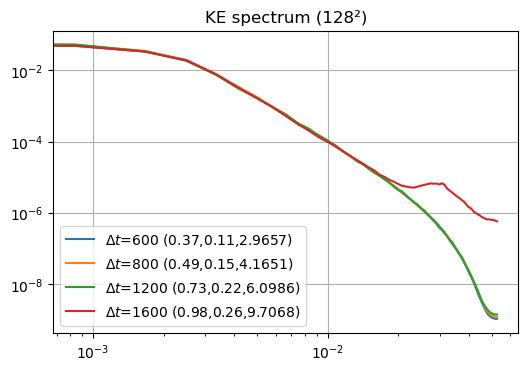

In [10]:
plt.figure(dpi=100);

plot( plt.loglog, KEsp, AHdt600, 600);
plot( plt.loglog, KEsp, AHdt800, 800);
plot( plt.loglog, KEsp, AHdt1200, 1200);
plot( plt.loglog, KEsp, AHdt1600, 1600);
plt.legend(); plt.grid(); plt.title('KE spectrum (128²)');

In [11]:
AHdt1200b = xarray.open_dataset('ArakawaHsu.Smag006.dt1200.64x64/prog.nc')
AHdt1800 = xarray.open_dataset('ArakawaHsu.Smag006.dt1800.64x64/prog.nc')
AHdt2400 = xarray.open_dataset('ArakawaHsu.Smag006.dt2400.64x64/prog.nc')
AHdt2880 = xarray.open_dataset('ArakawaHsu.Smag006.dt2880.64x64/prog.nc')
AHdt3200 = xarray.open_dataset('ArakawaHsu.Smag006.dt3200.64x64/prog.nc')
AHdt3600 = xarray.open_dataset('ArakawaHsu.Smag006.dt3600.64x64/prog.nc')

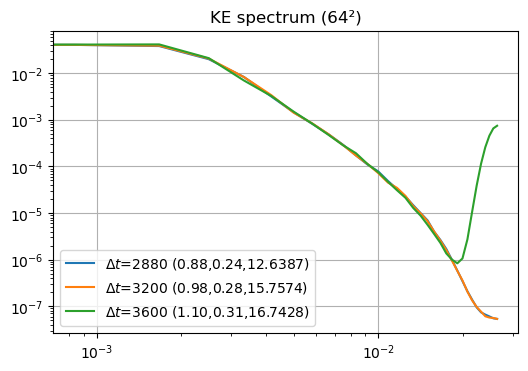

In [12]:
plt.figure(dpi=100);

# plot( plt.loglog, KEsp, AHdt1200b, 1200);
# plot( plt.loglog, KEsp, AHdt1800, 1800);
# plot( plt.loglog, KEsp, AHdt2400, 2400);
plot( plt.loglog, KEsp, AHdt2880, 2880);
plot( plt.loglog, KEsp, AHdt3200, 3200);
plot( plt.loglog, KEsp, AHdt3600, 3600);
plt.legend(); plt.grid(); plt.title('KE spectrum (64²)');

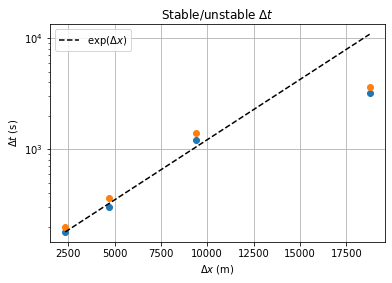

In [13]:
N = numpy.array([512,256,128,64])
dx = 1200e3/N
dt = numpy.array([[180,200],[300,360],[1200,1400],[3200,3600]])
plt.semilogy(dx, dt, 'o');
plt.plot(dx, 100*numpy.exp(dx/4e3), 'k--', label='exp($\Delta x$)' );
plt.xlabel('$\Delta x$ (m)'); plt.ylabel('$\Delta t$ (s)'); plt.title('Stable/unstable $\Delta t$');
plt.grid();
plt.legend();

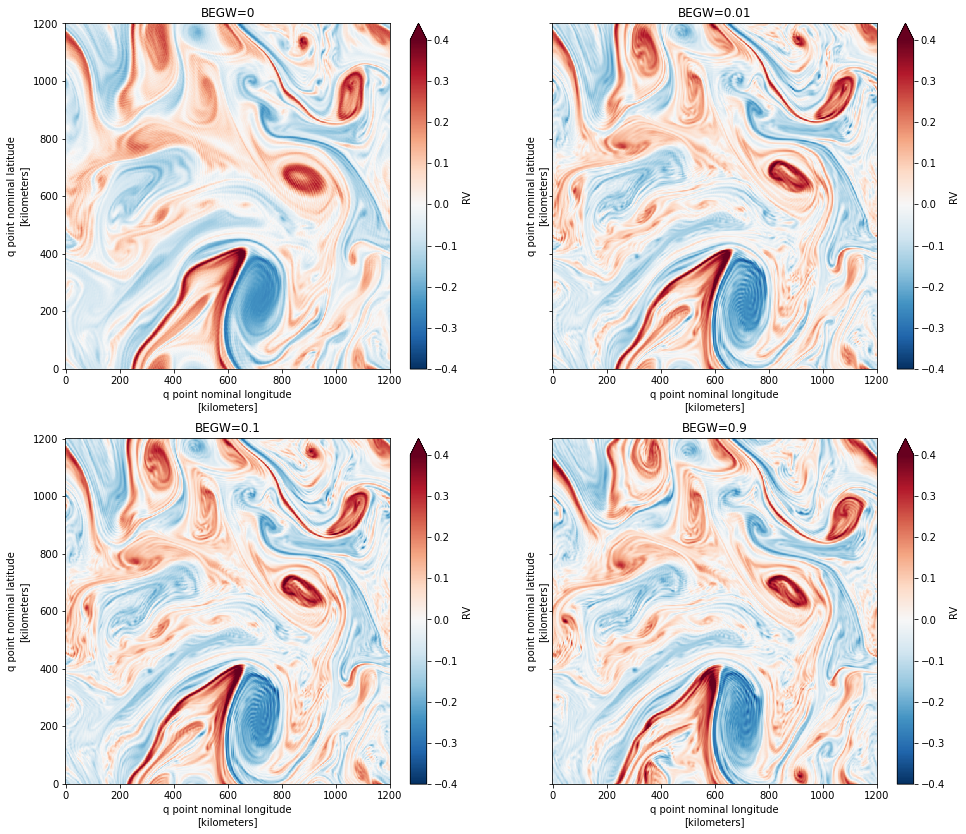

In [67]:
fig,ax=plt.subplots(2,2,figsize=(16,14),sharey=True);
time,opts=30,{'vmin':-.4, 'vmax':.4, 'cmap':plt.cm.RdBu_r}
(1e4*AHdt180.RV.isel(Time=time,zl=0)).plot(ax=ax[0,0], **opts); ax[0,0].set_title('BEGW=0');
(1e4*AHdt180gw01.RV.isel(Time=time,zl=0)).plot(ax=ax[0,1], **opts); ax[0,1].set_title('BEGW=0.01');
(1e4*AHdt180gw1.RV.isel(Time=time,zl=0)).plot(ax=ax[1,0], **opts); ax[1,0].set_title('BEGW=0.1');
(1e4*AHdt180gw.RV.isel(Time=time,zl=0)).plot(ax=ax[1,1], **opts); ax[1,1].set_title('BEGW=0.9');

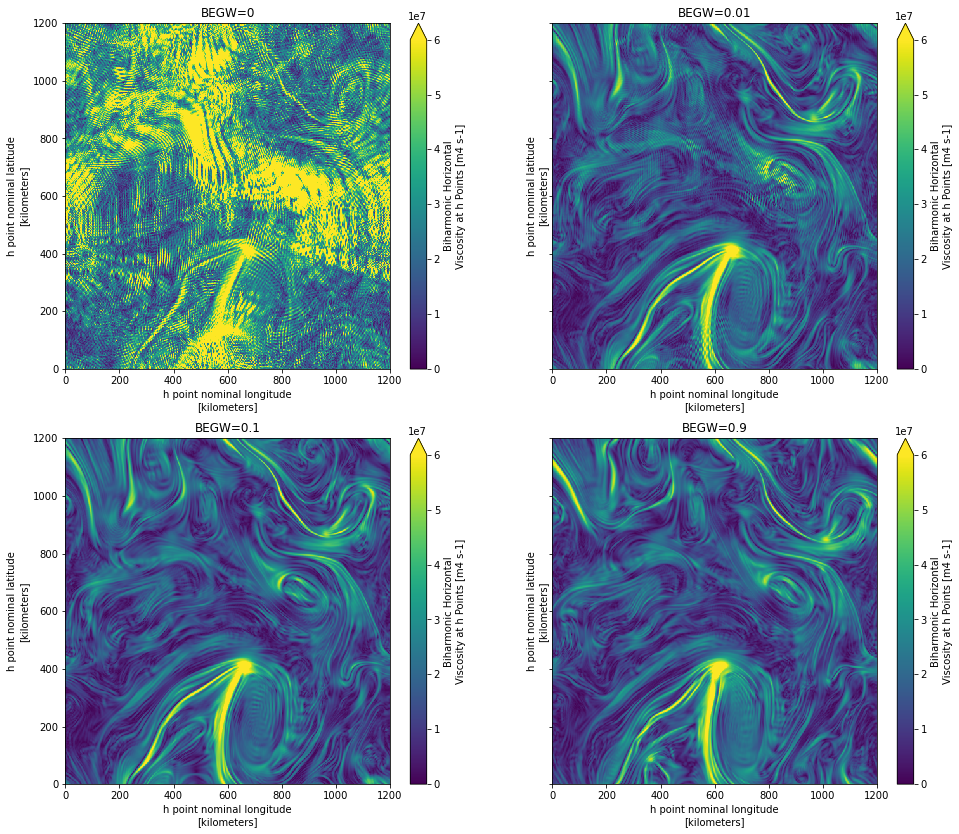

In [71]:
fig,ax=plt.subplots(2,2,figsize=(16,14),sharey=True);
time,opts=30,{'vmin':0, 'vmax':6e7}
(AHdt180.Ahh.isel(Time=time,zl=0)).plot(ax=ax[0,0], **opts); ax[0,0].set_title('BEGW=0');
(AHdt180gw01.Ahh.isel(Time=time,zl=0)).plot(ax=ax[0,1], **opts); ax[0,1].set_title('BEGW=0.01');
(AHdt180gw1.Ahh.isel(Time=time,zl=0)).plot(ax=ax[1,0], **opts); ax[1,0].set_title('BEGW=0.1');
(AHdt180gw.Ahh.isel(Time=time,zl=0)).plot(ax=ax[1,1], **opts); ax[1,1].set_title('BEGW=0.9');